I've always been interested in how machine learning can apply to visual arts. In particular, computer vision feels like the most direct application to art since we can build programs to classify, modify, and even generate visuals in an artistic fashion!

I'm by no means a deep learning aficionado but it's exciting to tinker around with the different tools and concepts I have at my disposal. In this notebook, we will be exploring how to build out an image classification model which classifies artwork based on their different types. 

We'll be using the fastai framework to speed up the development process and utilize modern deep learning techniques. Along the way, I will also be covering several different concepts that I have found useful in implementing vision models. I assume some level of familiarity with machine learning concepts such as epochs and mini-batch gradient descent. And ultimately, my hope is for this notebook to become the start of projects that inspire and help other deep learning practitioners along their own journeys!


# Inspiration, Toolkit, Data

The inspiration for this notebook comes from the computer vision lessons from [fastai](https://www.fast.ai/), a deep learning framework built mainly over [PyTorch](https://pytorch.org/). I'm continuing to use fastai for a few reasons:

*   The capability to train modern, well-tuned models right out of the box
*   High-level abstractions that can cooperate with low-level capabilities 
*   The focus on architecture and prototyping rather than granular details

For the image data, we will be using a Kaggle dataset called [Art Images: Drawing / Painting / Sculptures / Engravings](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving) which contains around 9000 images of 5 different types of art.

With a bit of that context out of the way, let's get started!

In [1]:
#| code-fold: true

# Fix for the progress bar not displaying correctly during training
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch


# Imports

In [2]:
from fastai.vision.all import *
from dotenv import load_dotenv
load_dotenv(override=True);

# Loading the Data

The dataset provided to us has already separated the data into training and validation sets in the directories `dataset/dataset_updated/training_set` and `dataset/dataset_updated/validation_set`, respectively.

To make the path structure a little simpler, we can move these directories to a directory called `data/`.

In [2]:
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

100%|███████████████████████████████████████▉| 582M/583M [00:24<00:00, 25.9MB/s]
100%|████████████████████████████████████████| 583M/583M [00:24<00:00, 24.8MB/s]


In [4]:
#| output: false
!unzip art-images-drawings-painting-sculpture-engraving.zip

Archive:  art-images-drawings-painting-sculpture-engraving.zip
  inflating: dataset/dataset_updated/training_set/drawings/01dee7c857692cce250fcc7fba309f3f.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/1007036943.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/10288_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/1601_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/167176.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/1677_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/2051_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/2200_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/2206_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/2208_mainfoto_05.jpg  
  inflating: dataset/dataset_updated/training_set/drawings/2211_mainfoto_05.jpg  
  inflating: dataset/dataset_updat

In [3]:
# Change the original directory path to data/
orig_data_path = Path('dataset/dataset_updated/')
path = Path('data')
if not path.exists():
    orig_data_path.rename(path)
    Path('dataset').rmdir()

Just to make sure all of our data is valid, let's check for any images we cannot open using the fastai `verify_images` function. If there are any failed images, we can remove them using `Path.unlink`.

In [4]:
# Retrieve image files on data path
im = get_image_files(path)

# Check to see which images we cannot open
failed = verify_images(im)
print(f'Number of images: {len(im)} | Number of failed: {len(failed)} | Remaining: {len(im) - len(failed)}')
failed

Number of images: 8577 | Number of failed: 0 | Remaining: 8577


(#0) []

In [5]:
failed.map(Path.unlink)

(#0) []

# Data Loading

At the core of fastai's data abstractions is their DataBlock API which is a high-level data loading API. We design our `DataBlock` with a few key questions in mind to make sure our data is loaded properly for training:

1.  `blocks`: What are the types of my inputs and targets?
2.  `get_items`: Where are we getting our data?
3.  `splitter`: How does our data need to be separated for cross-validation?
4.  `get_y`: What is our predicted target?
5.  `item_tfms`: How do we want to transform individual items?
6.  `batch_tfms`: How do we want to transform groups of items?

We then create a `DataLoaders` object from our `DataBlock` which will allow us to iterate over our dataset as a series of batches.

For our task of classifying different types of artwork, we will answer the previous questions with the following to help create the `DataBlock` we want:

1.  With images, we process our data with `ImageBlock` and set our target to single categories using `CategoryBlock`
2.  `get_image_files` can be used to get all our image data from a specified path
3.  We split our data into a training and valid dataset based on the grandparent directory each image is in using `GrandparentSplitter`
4.  The labels for our image targets will use the name of the directory they are located in using `parent_label`
5.  Every item will be resized to 460 pixel dimensions on the CPU
6.  We will apply a series of flip, rotate, zoom, warp, lighting transforms on whole batches of images using the GPU

For our task, we'll spin up a function `get_dls` to quickly spin up dataloaders with different batch and image sizes.

## Dataloader Function

In [6]:
def get_dls(bs: int, size: int) -> DataLoaders:
    """
    Creates a dataloader for an image recognition task with specified batch size and image size.

    # Parameters:
    -   bs (int): Batch size.
    -   size (int): Final size of individual images.

    # Returns:
    -   DataLoaders: A dataloader that batches our image data with specific image and batch size.
    """
    db = DataBlock(
        blocks=(ImageBlock(), CategoryBlock()),
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name='training_set', valid_name='validation_set'),
        get_y=parent_label,
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=size, min_scale=0.75)
    )
    return db.dataloaders(path, bs=bs)

When we create our dataloader, we can verify that our splitter is working as we expect it to.

In [7]:
dls = get_dls(64, 128)
len(dls.train_ds), len(dls.valid_ds)

(7721, 856)

In [8]:
# Verifying that the number of images in each directory is the same
exts = ['.jpg', '.jpeg', '.png']
len([p for p in (path / 'training_set').rglob('*') if p.suffix in exts]), len([p for p in (path / 'validation_set').rglob('*') if p.suffix in exts])

(7721, 856)

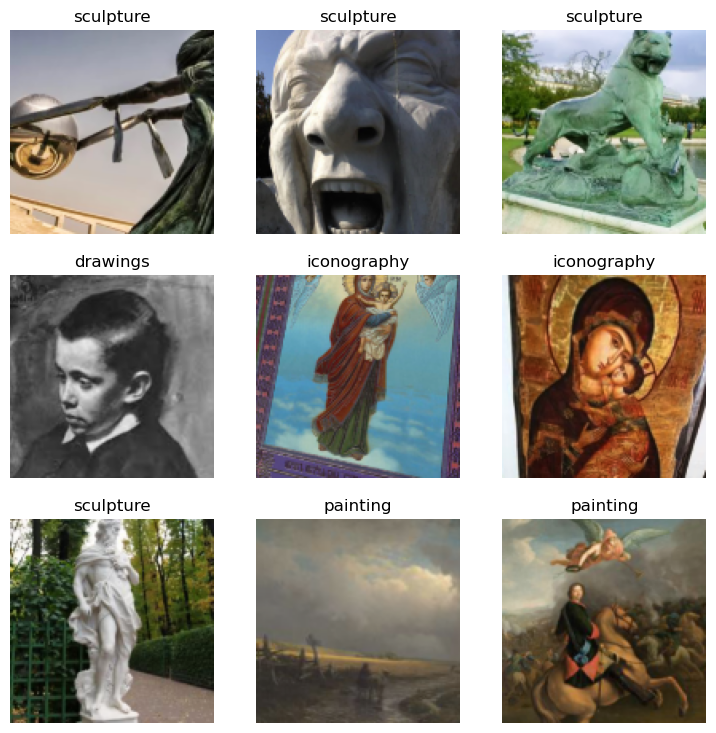

In [9]:
# Show an example batch of images
dls.show_batch()

# Model Specification, Training, Results Validation

Once our data is loaded in, our next step is to specify our model.

One key idea that I have taken away from fastai is the high effectiveness of using **transfer learning** for new machine learning tasks.

Transfer learning is a method of using pretrained models that were trained on one task as a starting point for training models on a new task. 

For computer vision tasks, fastai makes initializing a pretrained model simple through `vision_learner`--by default, the `pretrained` parameter is `True`. When we use a pretrained model, the last layer is replaced with a new linear layer with the same number of outputs as our new transfer learning problem (in this case 5 classes). However, this new layer is randomly initialized so we will need to make sure to tune our model to correctly predict the different artwork types.

To start, we will use the **resnet50** architecture and track the `accuracy` metric (percent of images predicted correctly). 

In [33]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

## Learning Rate Finder

For our model, we first need to select a good learning rate (LR) to start our training. Fastai implements an LR finder method `Learner.lr_find` based on Leslie Smith's paper called [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf).

Smith describes his approach as the following:

> There is a simple way to estimate reasonable minimum and maximum boundary values with one training run of the network for a few epochs. It is a “LR range test”; run your model for several epochs while letting the learning rate increase linearly between low and high LR values.

Essentially, we check our training losses as we grow our learning rate to get an idea of what learning rate performs well.

Fastai takes a slightly different approach: The model is test-trained with learning rates that grow exponentially from a low LR to a higher LR across a number of mini-batches. The process continues until we find a learning rate where the loss begins to diverge and increases significantly.

What this boils down to is that in the fastai version we don't necessarily need to run for multiple epochs to get an optimal LR as we are training for a set number of mini-batches.

<!-- Do I need this part? Maybe not. Seems wordy -->
Conveniently, `lr_find` gives us the loss vs. LR plot and also enables us to directly extract LRs that could be optimal based off different *suggestion* functions. For example, I will use `steep` which gets the LR with the steepest slope. 

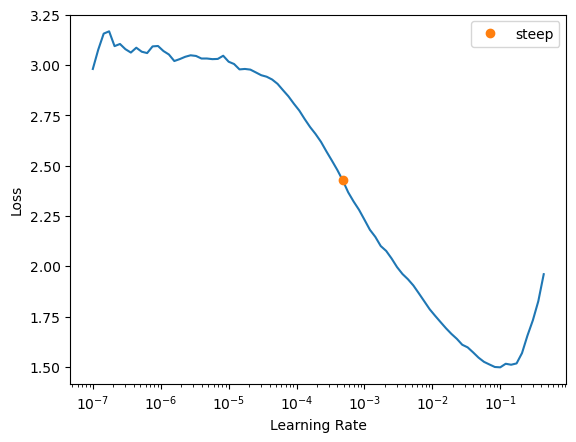

In [34]:
#| fig-cap: Log plot of loss vs. learning rate

lr_steep = learn.lr_find(suggest_funcs=steep)

## 1cycle Idea

We can now start training our model! Using the `fit_one_cycle` method we are actually training our model with what is called the **1cycle policy**, an idea that again comes from Leslie Smith and changes our learning rate over the course of training. I won't be going into close detail on how the 1cycle policy is implemented in the scope of this article. At a high level, we are starting at some initial LR, linearly increasing our LR after every batch up to a maximum LR, and from the maximum LR down to some minimum LR several magnitudes lower than our initial LR. 

The idea behind this all is to warm up our training with a low learning rate and use the high learning rate to help find minimums in our loss function that are flatter, allowing the model to generalize better. During the last segment of training, the descending learning rates help the optimizer avoid skipping over a steeper loss within the flatter areas. This process allows our model to converge faster and consequently achieve better results with lower iterations than traditional training methods. Smith calls this occurrence **super-convergence.**

In [12]:
#| code-fold: true


def plot_example_cycle(x_min, x_max, y_min, y_max, padding):
    values = 100
    x = np.linspace(x_min, x_max, values + padding)

    y1 = np.linspace(y_min, y_max, values // 2, endpoint=False)
    y2 = np.linspace(y_max, y_min, values // 2, endpoint=False)
    padded_values = np.linspace(y_min, y_min * 1e-2, padding)

    y = np.concatenate((y1, y2, padded_values))

    plt.plot(x, y)
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

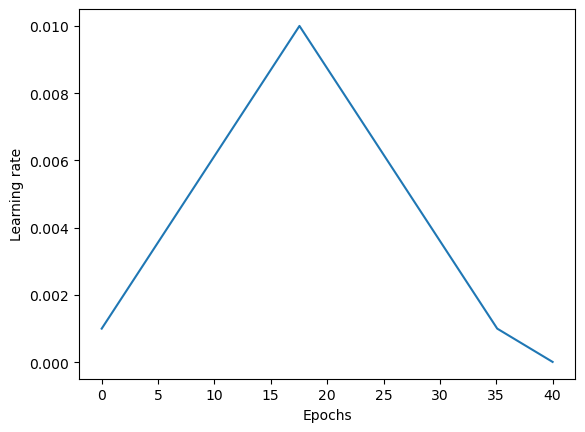

In [13]:
#| label: fig-1cycle-example
#| fig-cap: Example representation of a linear 1cycle learning rate schedule.

plot_example_cycle(0, 40, 0.001, 0.01, 15)

<!-- Now that I'm using fine_tune method this section needs a bit of revision -->
With transfer learning, our model has additional new layers that we can train for the problem we are trying to solve. At the start of training, we may not want to completely readjust the weights in the model's previously learned layers because they account for high-level details of the image like line and shape.

In a pretrained model, the previous trained layers start out **frozen**, meaning their weights aren't updated during training unless we unfreeze them. Later, we will unfreeze all the layers and use a range of learning rates to help adjust them slightly for our artwork classification.

Fastai recommends training the frozen pretrained model for a few epochs before training the full pretrained model. We'll start with 3 epochs frozen using the learning rate we found before and then train the full model for 25 epochs. We can get an idea of how our error rates changes across training from here. Our losses along with our metrics will be useful in determining if we've fitted a decent model or whether we are underfitting or overfitting.

In [35]:
learn.fit_one_cycle(3, lr_steep.steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.632305,0.351879,0.885514,00:11
1,0.367901,0.266535,0.911215,00:11
2,0.290731,0.255560,0.912383,00:11


SuggestedLRs(valley=3.0199516913853586e-05)

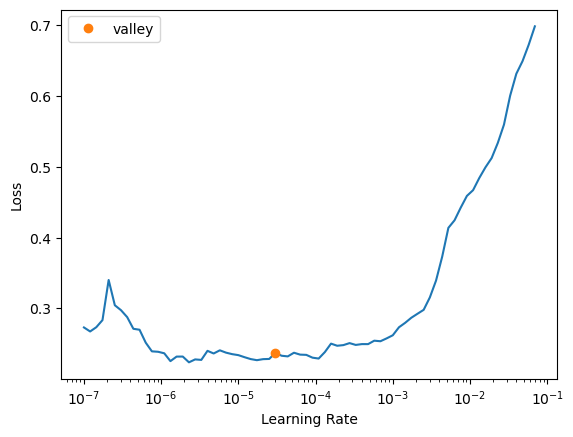

In [36]:
learn.unfreeze()
learn.lr_find()

In [37]:
learn.fit_one_cycle(30, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.278328,0.252081,0.913551,00:12
1,0.270599,0.246448,0.917056,00:12
2,0.257108,0.233751,0.920561,00:12
3,0.248420,0.236578,0.913551,00:12
4,0.225075,0.217247,0.922897,00:12
5,0.219640,0.218755,0.921729,00:12
6,0.193035,0.220623,0.927570,00:12
7,0.181702,0.207903,0.929907,00:12
8,0.153848,0.203974,0.931075,00:13
9,0.140883,0.205168,0.928738,00:12


## Interpreting the Loss Curves, Further Training?

After training our model, we will see how our training and validation losses have changed over the course of our iteration / epochs using **loss curves**. Loss curves won't provide the entire story of our model but we'll have a broad picture of how our model performs over the selected dataset and batch size.

Text(0, 0.5, 'Loss')

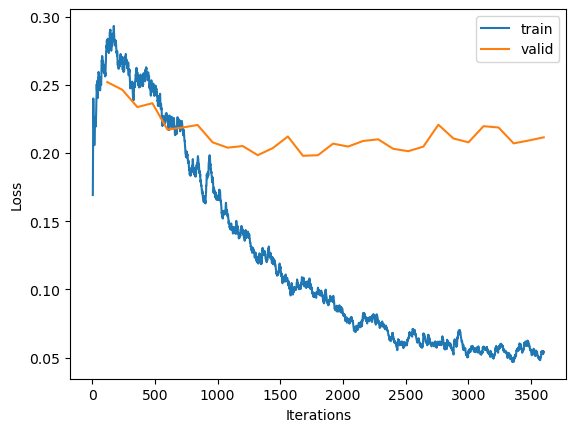

In [39]:
learn.recorder.plot_loss()
plt.xlabel("Iterations")
plt.ylabel("Loss")

Initially, our validation loss starts out lower than our training loss but our training loss quickly converges as our training progresses.

We should note that we reach a point where our validation loss is higher than our training loss. The former also does not seem to converge any more which leads us to an important question: are we **overfitting**?

## Overfitting

Overfitting occurs when we have trained for too long and the model begins to "memorize" the training data while failing to generalize well to new data. 

When we look at our losses, we might decide an increasing validation loss with a continually decreasing training loss means we are overfitting. However, this is not necessarily the case--one key takeaway from fastai is that we should be checking if our performance metric is getting worse to decide if the model is overfitting.

Highest accuracy during last run: 14


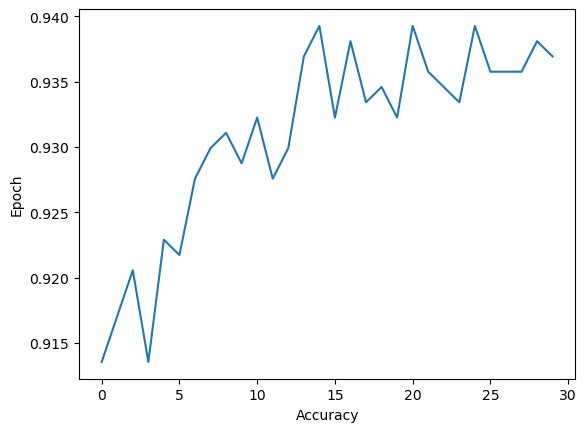

In [41]:
accuracy_metric = L(learn.recorder.values).itemgot(2)
print(f'Highest accuracy during last run: {np.argmax(accuracy_metric)}')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.xticks(np.arange(0, len(accuracy_metric) + 1, 5))
plt.plot(accuracy_metric);

Our highest accuracy is at epoch 14 and it doesn't show clear signs of improvement with additional training. If we take into account both our validation loss and metric, then our model *might* be overfitting but it's not clear. However, we have a few options here! We could introduce regularization, choose a deeper architecture or even rerun our model with a lower number of epochs and adjust from there. In this case, we will select a deeper architecture using discriminative learning rates. Using a deeper model, we might be able to learn the patterns of our data better.

We should keep in mind that our performance metric is what ultimately matters in practice. 

As Jeremy Howard states: 

> "In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize."
>
> "Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice."

To really evaluate our model's performance, we would run our model on a representative test data set that it has never seen before. This would help us get a good idea of our model's practical performance.

In [44]:
#| warning: false

# Reinitialize our model to restart training
learn = vision_learner(dls, resnet101, metrics=accuracy)

/home/yang/miniconda3/envs/fastai-learn/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yang/miniconda3/envs/fastai-learn/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
lr_steep = learn.lr_find(suggest_funcs=steep, show_plot=False)

learn.fit_one_cycle(3, lr_steep.steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.630548,0.262199,0.907710,00:14
1,0.352523,0.220467,0.919393,00:14
2,0.275075,0.213857,0.920561,00:14


SuggestedLRs(valley=1.737800812406931e-05)

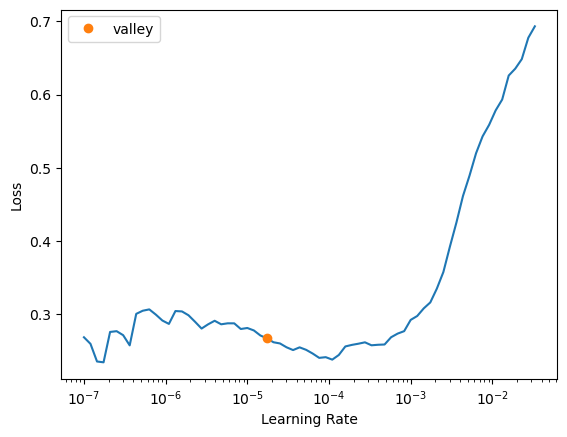

In [46]:
learn.unfreeze()
learn.lr_find()

In [47]:
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.271231,0.216878,0.915888,00:17
1,0.233810,0.186462,0.928738,00:17
2,0.212894,0.168020,0.928738,00:17
3,0.175912,0.168379,0.927570,00:17
4,0.156709,0.168505,0.933411,00:17
5,0.136558,0.161048,0.948598,00:17
6,0.124741,0.157284,0.936916,00:17
7,0.105511,0.157003,0.943925,00:18
8,0.105623,0.155143,0.947430,00:17
9,0.108300,0.154238,0.945093,00:18


We improved our accuracy up to around 94% by using a deeper model with discriminative learning rates. However, every choice has tradeoffs. Training a deeper model takes more time in general and in our low-risk context the increase in accuracy could be neglible. Let's take a closer look at how our fine-tuned model is doing on our image set.

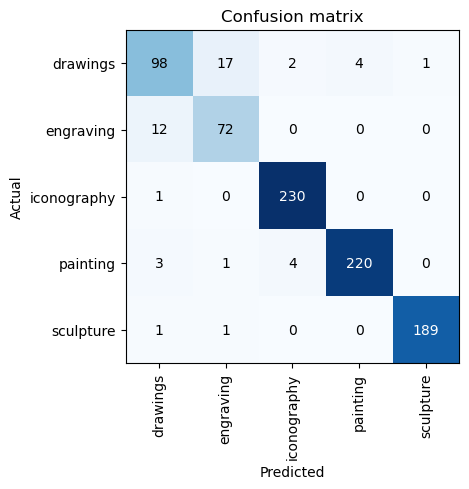

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [51]:
interp.print_classification_report()

              precision    recall  f1-score   support

    drawings       0.85      0.80      0.83       122
   engraving       0.79      0.86      0.82        84
 iconography       0.97      1.00      0.99       231
    painting       0.98      0.96      0.97       228
   sculpture       0.99      0.99      0.99       191

    accuracy                           0.95       856
   macro avg       0.92      0.92      0.92       856
weighted avg       0.95      0.95      0.95       856



The weighted F1-score is the the mean of all the class F1 scores while taking into account the number of occurrences in each class. The score has a range from 0 to 1. Our model achieved a weighted F1-score of **0.95**. Not bad!

In production, we should take these results with a grain of salt since we haven't done any true performance testing. But it's fascinating that we can achieve such results with just a bit of conceptual understanding and a few lines of code!

# Prediction / Inference

The last thing I want to cover is how we can use our newly trained model to make predictions on new artwork images. We first export our model:

In [52]:
# Save model into models/
model_path = Path('models')
learn.export(model_path / 'artwork.pkl')

In [55]:
# Load model and display the unique classes that can be predicted by the model
artwork_model = load_learner(model_path / 'artwork.pkl')
artwork_model.dls.vocab

['drawings', 'engraving', 'iconography', 'painting', 'sculpture']

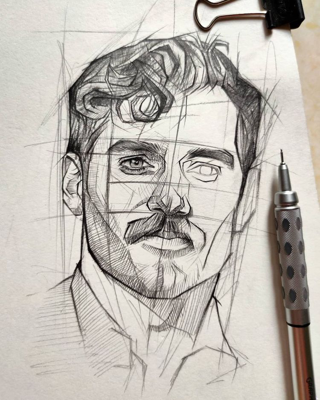

In [71]:
# Retrieve the image for inference
inf_path = Path('inference')
img_inf = PILImage.create(inf_path / 'drawing_1.jpeg')
img_inf.to_thumb(400)

In [69]:
# Get a list of individual probabilities for each class
list(zip(artwork_model.dls.vocab, artwork_model.predict(img_inf)[2] * 100))

[('drawings', tensor(77.8390)),
 ('engraving', tensor(22.1252)),
 ('iconography', tensor(0.0320)),
 ('painting', tensor(0.0001)),
 ('sculpture', tensor(0.0037))]

Our model correctly predicts that our image is a drawing with a 77.8% probability.

# Further Steps / Moving Forward

We covered a lot of concepts! Deep learning and data science as a whole is an art form. For every step in the model development process there are always more design choices and optimizations we could have made. I'm eager to explore every single concept I've been learning about, but there is too much to cover in a single article. I chose to focus on the concepts that I think will help readers understand essential elements of fastai and deep learning. 

Here are a few deep learning concepts (computer vision and general topics) that I would love to cover in future posts:

-   Multi-label classification
-   Data augmentation: Progressive resizing, mixup, cutout
-   Convolution neural networks in detail

Happy learning!